# Importing Packages

In [6]:
# General
import os
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pandas as pd
from collections import defaultdict

# Pre-processing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

# Neural Network
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.models import model_from_json

#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Save/Load Model 

In [ ]:
# Saving Model and weiths
# serialize model to JSON
model_json = model.to_json()
with open("hippo_model_24thJune_NoisleesScrapped_DefaultDBSCAN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hippo_model_24thJune_NoisleesScrapped_DefaultDBSCAN.h5")
print("Saved model to disk")
 
'''
# load json and create model
json_file = open('hippo_model_20thJune_NoisleesURL_DefaultDBSCAN_SmallEPS.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("hippo_model_20thJune_NoisleesURL_DefaultDBSCAN_SmallEPS.h5")
print("Loaded model from disk")
'''

# Loading Data

In [2]:
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
text_path = 'data/data_NN_no_noise_Scrapped - Noisless url_keywords.txt'# scrapped data, no noise based on dbscan
with open(text_path) as f:
    data = [text.strip() for text in f]
print("Total: %s short texts" % format(len(data), ","))

Total: 3,537 short texts


# Second Level Pre-processing 

In [3]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len

Found 283 unique tokens.
Minumum length: 1
Average length: 3
Max length: 27


In [4]:
######################################
# Loading word2vec & embedding matrix#
######################################
print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 81


In [7]:
###################################################
#Preparing training labels with Average Embeddings#
###################################################
dimen_vect = {}
#binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') similar results as count
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count')
normed_value = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
dimen_vect["ae"] = average_embeddings
print("Shape of average embedding: ", dimen_vect['ae'].shape)
reduction_name = "ae" # average embedding
B = preprocessing.Binarizer().fit_transform(dimen_vect[reduction_name]) 

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

print(B.shape)
print(B[1])

Shape of average embedding:  (3537, 300)
(3537, 300)
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]


# Neural Network Design 

In [8]:
def NN():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    filters = [3,4,5]
    
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    spatial_x = SpatialDropout1D(0.1)(embedded_sequences)
    
    # Layers
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    
    # Dense
    x = Dense(256,activation = 'tanh')(merged) # best performing
    
    # DropOut
    x = Dropout(0.1)(x)
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)
    model.layers[1].trainable=trainable_embedding #embedding layer
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    

    model.summary()
    plot_model(model, to_file='model_plot_no_shapes.png', show_shapes=False, show_layer_names=True) # saving model
    return model

# Training

In [9]:
nb_epoch = 12 #changed from 50 cause of time limitations
checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = NN()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 300)      85200       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 27, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)    

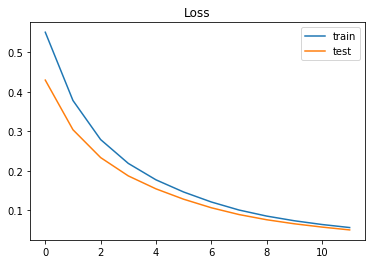

In [10]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

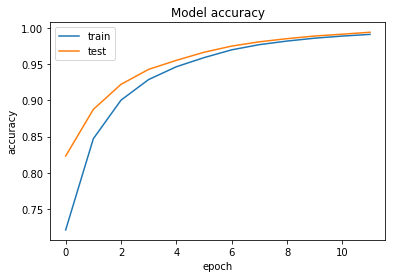

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Preping results
# create model that gives penultimate layer - the layer before the last
input1 = model.layers[0].input
output = model.layers[-2].output
model_penultimate = Model(input1, output)

# Generating Deep-feature representation
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))

# Applying L2 Normalization
V_penul = normalize(H_penul, norm='l2') # norm

Sample shape: (3537, 256)


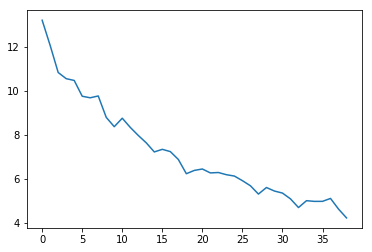

In [14]:
# Amount of Clusters based on Penul data
# Wherever it makes the curve switch - around 6-7 for this data
# Used for Elbow Method

import numpy as np
from scipy import cluster
from matplotlib import pyplot


#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(H_penul,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

# DBSCAN - Removing noise

Estimated number of clusters: 101
Estimated number of noise points: 45
Silhouette Coefficient: 0.978


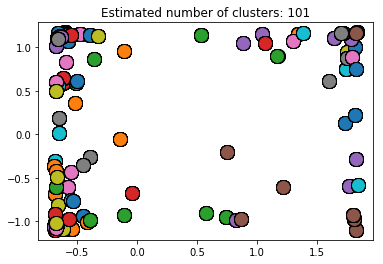

In [15]:
X_DBSCAN = StandardScaler().fit_transform(H_penul)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(H_penul)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_DBSCAN, labels))

# Plot result - DBSCAN
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_DBSCAN[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Storing Locally

In [ ]:
# labels is from DBSCAN
Output_D = []
for i in range(len(data)):
    d.append({'Keywords_CNN': data[i], 'Sequence_Full': sequences_full[i], 'Prediction':labels[i]})
Output_D= pd.DataFrame(Output_D)
Output_D.head(1)
#Output_D.to_csv('CNN_Demo-HippoBased_Test.csv')

In [ ]:
Output_D.sort_values('Prediction')

In [ ]:
# - 1 for outliers based on DBSCAN
Output_D = Output_D[Output_D.Prediction != -1]

# Creating Training Data without Noise

In [ ]:
importName = 'CNN_Demo-HippoBased_Labels.xls'
cluster_labels = pd.read_excel(importName)

In [ ]:

keywords_list = Output_D["Keywords_CNN"].tolist()
data_NN_no_noise = []
for i in keywords_list:
    data_NN_no_noise.append(i)
with open('data_NN_URL_No_Noise_Testing.txt', 'w') as f:
    for item in data_NN_no_noise:
        f.write("%s\n" % item)

# Silhouette value - plot

In [ ]:
init_variable = H_penul
pair_dist = pairwise_distances(init_variable,metric='euclidean', n_jobs=-1)
range_n_clusters = range(27, 28)

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(22, 14)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(init_variable) + (n_clusters + 1) * 10])
    kmeans = KMeans(n_clusters=n_clusters, verbose=0)
    kmeans.fit_predict(init_variable)


    kmeans_labels = kmeans.labels_
    silhouette_avg = silhouette_score(pair_dist, kmeans_labels, metric='precomputed')

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(pair_dist, kmeans_labels, metric='precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[kmeans_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(("Silhouette analysis for KModes clustering "
                  "with clusters = %d" % n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
    
    
    #plt.savefig('silhouette_score_bars.png', format='png', dpi=400)
    plt.show()

# Merge Final Output - Clusters + Keywords

In [ ]:
# Merge the visitor data with clusters
'''
    Here we merge the predictions with the user data based on the keywords
'''

In [ ]:
# Import from First Level Pre-processing with user data
importName = 'data/ForEvaluation.csv'
user_data_import = pd.read_csv(importName, sep=',')

In [ ]:
user_data_import = user_data_import.drop('Unnamed: 0', 1)
user_data_import.head(1)

In [ ]:
# clean dict from cnn
new_d = dict(zip(Output_D.Prediction,Output_D.keywords))

In [ ]:
# clean dict with visitor
new_user_data_import = dict(zip(user_data_import.transactionPath,user_data_import.keywords))

In [ ]:
new_user = {}
for key,value in new_user_data_import.items():
    dataOutput = eval(value) # How to convert list lookalike into a list?
    new_user[key] = dataOutput

In [ ]:
# merging
merged_data = user_data_import.sort_values('keywords', ascending=False)
merged_data["Numeric_Label"] = merged_data['visitorId']
d.reset_index(drop=True)
merged_data.reset_index(drop=True)
merged_data.head(1)

In [ ]:
# cluster_labels_dict
cluster_labels_dict = defaultdict(list)
list1 = d['Prediction'].tolist()
list2 = d['keywords'].tolist()
for key, value in zip(list1, list2):
    cluster_labels_dict[key].append(value)

In [ ]:
result_dict = {}
for key, value in cluster_labels_dict.items():
    for i in value:
        for key_clean, value_clean in new_user.items():
            if sorted(value_clean) == sorted(i):
                result_dict[key_clean] = key

In [ ]:
merged_data['Numeric_Label'] = merged_data['transactionPath'].map(result_dict)
merged_data['Numeric_Label'].fillna('missing', inplace=True)
merged_data = merged_data.reset_index(drop=True)
merged_data.to_csv('CNN_Merge_Test.csv')